In [92]:
import polars.selectors as cs
import numpy as np

import polars as pl

import matplotlib.pyplot as plt

import matplotlib as mpl
import matplotlib_inline.backend_inline

import matplotlib.pyplot as plt

LATEX = False
if LATEX:
    mpl.rcParams['text.usetex'] = True
    mpl.rcParams["font.family"] = "serif"
    mpl.rcParams["font.serif"] = "Times"
else:
    mpl.rcParams['text.usetex'] = False
    mpl.rcParams["font.family"] = "Times New Roman"
    mpl.rcParams["mathtext.fontset"] = "stix"
    
plt.rcParams['svg.fonttype'] = 'none'
mpl.rcParams['savefig.dpi'] = 300

matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

mpl.rcParams['axes.titleweight'] = 'bold'

mpl.rcParams['legend.fancybox'] = False
mpl.rcParams['legend.frameon'] = False

In [93]:
def hist_of_numerical_values(df: pl.DataFrame):
    """
    Generates histograms for all numerical columns in a Polars DataFrame.

    Args:
        df: The Polars DataFrame.

    Returns:
        A dictionary where keys are column names and values are the histogram data.
    """
    histograms = {}
    for col_name in df.columns:
        if df[col_name].dtype in [pl.Int8, pl.Int16, pl.Int32, pl.Int64, pl.UInt8, pl.UInt16, pl.UInt32, pl.UInt64, pl.Float32, pl.Float64]:
            hist_data = df[col_name].hist()
            histograms[col_name] = hist_data
    return histograms

In [144]:
index_cols = {
    20: []
}
scale_required = set([4, 5, 6, 7, 9, 12, 13, 17, 19, 21, 22])
# not 8, 14
# skip 3, skip 20
queries_to_run = [20]

In [145]:
query_ind = 20
null_info = {}
orig = pl.read_csv(f'../unnoised/q{query_ind}.csv')
noised = pl.read_json(f'../outputs/ap-duckdb-q{query_ind}-customer-0.5-step3/output.json')
orig = orig.with_row_index(name="rank")
noised = noised.with_row_index(name="rank")
merged_df = orig.join(noised, suffix='_noised',  on="rank")

In [146]:
orig

rank,s_name,s_address
u32,str,str
0,"""Supplier#000000020""","""JtPqm19E7tF 152Rl1wQZ8j0H"""
1,"""Supplier#000000091""","""35WVnU7GLNbQDcc2TARavGtk6RB6ZC…"
2,"""Supplier#000000205""","""Alrx5TN,hdnG"""
3,"""Supplier#000000285""","""q TMZEDyZtv vUiFKBhT3NJlnIxpL"""
4,"""Supplier#000000287""","""UQR8bUA4V2HxVbw9K"""
…,…,…
181,"""Supplier#000009811""","""nXIxtBT6D1v6TCb2iMYkyU"""
182,"""Supplier#000009812""","""rbl9euXFoPLlKQVYDVyRouslbbbKDH…"
183,"""Supplier#000009846""","""WTzdvihXbyqnx0JfbbVaxBOcO9d93D…"


In [97]:
for ind in range(10):
    print(ind, set(merged_df[ind]['s_name_noised'].to_list()[0]))

0 {'Supplier#000000287', 'Supplier#000000091', 'Supplier#000000020', 'Supplier#000000285', 'Supplier#000000205'}
1 {'Supplier#000000287', 'Supplier#000000091', 'Supplier#000000378', 'Supplier#000000354', 'Supplier#000000285', 'Supplier#000000205'}
2 {'Supplier#000000287', 'Supplier#000000378', 'Supplier#000000354', 'Supplier#000000285', 'Supplier#000000402', 'Supplier#000000205', 'Supplier#000000530'}
3 {'Supplier#000000640', 'Supplier#000000287', 'Supplier#000000378', 'Supplier#000000729', 'Supplier#000000354', 'Supplier#000000285', 'Supplier#000000402', 'Supplier#000000555', 'Supplier#000000530'}
4 {'Supplier#000000761', 'Supplier#000000640', 'Supplier#000000287', 'Supplier#000000887', 'Supplier#000000378', 'Supplier#000000729', 'Supplier#000000354', 'Supplier#000000402', 'Supplier#000000736', 'Supplier#000000555', 'Supplier#000000530'}
5 {'Supplier#000000761', 'Supplier#000000935', 'Supplier#000000640', 'Supplier#000000378', 'Supplier#000000729', 'Supplier#000000975', 'Supplier#0000

In [101]:
import json
for mi in [1/128, 1/64, 1/32, 1/16, 1/8, 1/4, 1/2, 1.0, 2.0, 4.0]:
    for ind in range(5):
        d=json.load(open(f'../outputs/ap-duckdb-q20-customer-{mi}-step2/{ind}.json', 'rb'))
        print(mi, ind, d['frac_nulls'])

0.0078125 0 0.0
0.0078125 1 0.0
0.0078125 2 0.0
0.0078125 3 0.0
0.0078125 4 0.0
0.015625 0 0.0
0.015625 1 0.0
0.015625 2 0.0
0.015625 3 0.0
0.015625 4 0.0
0.03125 0 0.0
0.03125 1 0.0
0.03125 2 0.0
0.03125 3 0.0
0.03125 4 0.0
0.0625 0 0.0
0.0625 1 0.0
0.0625 2 0.0
0.0625 3 0.0
0.0625 4 0.0
0.125 0 0.0
0.125 1 0.0
0.125 2 0.0
0.125 3 0.0
0.125 4 0.0
0.25 0 0.0
0.25 1 0.0
0.25 2 0.0
0.25 3 0.0
0.25 4 0.0
0.5 0 0.0
0.5 1 0.0
0.5 2 0.0
0.5 3 0.0
0.5 4 0.0
1.0 0 0.0
1.0 1 0.0
1.0 2 0.0
1.0 3 0.0
1.0 4 0.0
2.0 0 0.0
2.0 1 0.0
2.0 2 0.0
2.0 3 0.0
2.0 4 0.0
4.0 0 0.0
4.0 1 0.0
4.0 2 0.0
4.0 3 0.0
4.0 4 0.0


In [102]:
d=json.load(open(f'../outputs/ap-duckdb-q20-customer-{mi}-step2/{ind}.json', 'rb'))

In [103]:
merged_df

rank,s_name,s_address,s_name_noised,s_address_noised
u32,str,str,list[str],list[str]
0,"""Supplier#000000020""","""JtPqm19E7tF 152Rl1wQZ8j0H""","[""Supplier#000000285"", ""Supplier#000000285"", … ""Supplier#000000287""]","[""UQR8bUA4V2HxVbw9K"", ""Alrx5TN,hdnG"", … ""Alrx5TN,hdnG""]"
1,"""Supplier#000000091""","""35WVnU7GLNbQDcc2TARavGtk6RB6ZC…","[""Supplier#000000378"", ""Supplier#000000354"", … ""Supplier#000000285""]","[""wSLcCW40Q8"", ""UQR8bUA4V2HxVbw9K"", … ""UQR8bUA4V2HxVbw9K""]"
2,"""Supplier#000000205""","""Alrx5TN,hdnG""","[""Supplier#000000205"", ""Supplier#000000530"", … ""Supplier#000000287""]","[""wSLcCW40Q8"", ""mLPJtpu4wOc cSFzBR"", … ""q TMZEDyZtv vUiFKBhT3NJlnIxpL""]"
3,"""Supplier#000000285""","""q TMZEDyZtv vUiFKBhT3NJlnIxpL""","[""Supplier#000000640"", ""Supplier#000000285"", … ""Supplier#000000402""]","[""0BvoewCPg2scOEfuL93FRKqSxHmdhw1"", ""FwwyFbgz7c hHViKGT0OB"", … ""wSLcCW40Q8""]"
4,"""Supplier#000000287""","""UQR8bUA4V2HxVbw9K""","[""Supplier#000000402"", ""Supplier#000000555"", … ""Supplier#000000287""]","[""tF8fMGa6HY4 w77mDwT4rO21kxwe7uTSYNW"", ""0BvoewCPg2scOEfuL93FRKqSxHmdhw1"", … ""CAOGYCBtTVT7aB1p6qHbxF6VVhXaHLgTpI""]"
…,…,…,…,…
148,"""Supplier#000007760""","""izbmZTbwONm7g""",[null],[null]
149,"""Supplier#000007801""","""VRLI07Z UME6Pr""",[null],[null]
150,"""Supplier#000007865""","""WOnko907Ud""",[null],[null]


In [104]:
full_df = pl.DataFrame()
for mi in [1/128, 1/64, 1/32, 1/16, 1/8, 1/4, 1/2, 1.0, 2.0, 4.0]:
    orig = pl.read_csv(f'../unnoised/q{query_ind}.csv')

    noised = pl.read_json(f'../outputs/ap-duckdb-q{query_ind}-customer-{mi}-step3/output.json')
    orig = orig.with_row_index(name="rank")
    noised = noised.with_row_index(name="rank")
    merged_df = orig.join(noised, suffix='_noised',  on="rank")
    suffix1 = ''
    suffix2 = '_noised'
    cols_with_suffixes = [col for col in merged_df.columns if suffix1 in col and suffix2 in col]
    base_names = set([col.replace(suffix1, '').replace(suffix2, '') for col in cols_with_suffixes])
    for base_name in base_names:
        nulls_exist = False
        null_inds, null_vals = [], []

        orig = base_name + suffix1
        noised = base_name + suffix2
#         print(orig, noised)
        if orig in merged_df.columns and noised in merged_df.columns:
            rel_errors = []
            for ind in range(len(merged_df[orig])):
                releases = merged_df[noised][ind].to_list()
                filtered_releases = [x for x in releases if x is not None]
                if len(filtered_releases) == 0:
                    rel_errors.append(None)
                    continue
                actual = merged_df[orig][ind]
                pct_agreement = 100*releases.count(actual) / len(releases)
                rel_errors.append(pct_agreement)
            merged_df = merged_df.with_columns(pl.Series('pct_agreement_' + base_name, rel_errors))
        merged_df = merged_df.with_columns(pl.Series('mi', [mi]*len(rel_errors)))
    full_df = pl.concat([full_df, merged_df])

In [148]:
merged_df[117]

rank,s_name,s_address,s_name_noised,s_address_noised
u32,str,str,list[str],list[str]
117,"""Supplier#000006297""","""UX59ndcVUk7otwOX,C2h""","[""Supplier#000009811"", ""Supplier#000007865"", … ""Supplier#000009846""]","[""An8q0oRCbe1UVde5ml Elgqx"", ""ariCwjAsnIY0ajDRA1GZv8WJkrKMFJcWtH"", … ""An8q0oRCbe1UVde5ml Elgqx""]"


In [149]:
118/186.

0.6344086021505376

In [141]:
orig = pl.read_csv(f'../unnoised/q{query_ind}.csv')
orig_key = ['s_name', 's_address']

agreement = {}

for key_ind, key in enumerate(['s_name_noised',  's_address_noised']): # ,
    ious = []
    for mi in  [1/128, 1/64, 1/32, 1/16, 1/8, 1/4, 1/2, 1.0, 2.0, 4.0]: #
        merged_df = full_df.filter(pl.col('mi') == mi)
        responses = {}

        for rank in range(len(merged_df)):
            rank_i_responses = merged_df[rank][key].to_list()[0]
            for ind in range(len(rank_i_responses)):

                if ind not in responses:
                    responses[ind] = []
                if rank_i_responses[ind] is not None:
                    responses[ind].append(rank_i_responses[ind])
        for ind in responses:
            responses[ind] = {k for k in set(responses[ind]) if k is not None}

        a = set(orig[orig_key[key_ind]].to_list())
        iou = []
        for t in responses:
            intersect = len(a.intersection(responses[t]))
            union = len(a.union(responses[t]))
            if union > len(a):
                print('union has more than orig data')
            iou.append(intersect/union)
        ious.append(100*np.average(iou))
    agreement[orig_key[key_ind]] = ious

In [142]:
len(merged_df[0]['s_name_noised'].to_list()[0])

1000

Q20
[46.59516129032258, 46.6005376344086, 46.63709677419355, 46.5989247311828, 46.636559139784936, 46.70591397849462, 46.65537634408602, 46.7258064516129, 46.71612903225807, 46.63118279569892]
reached
[46.69139784946236, 46.71075268817205, 46.66827956989247, 46.66129032258064, 46.619354838709675, 46.66881720430107, 46.63978494623655, 46.48494623655914, 46.618817204301074, 46.59462365591397]
reached


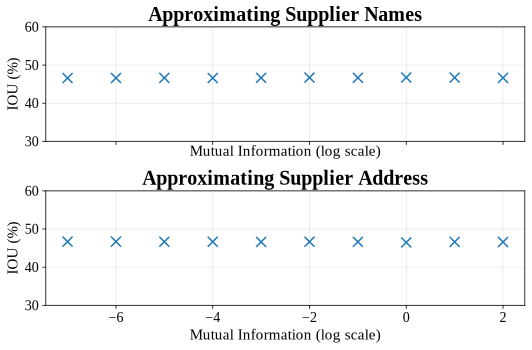

In [143]:
print("Q20")
mis = [1/128, 1/64, 1/32, 1/16, 1/8, 1/4, 1/2, 1.0, 2.0, 4.0]
xs = [np.log2(x) for x in mis]
fig, axes = plt.subplots(2, 1, figsize=(7.5, 5), sharex=True)
for ind, key in enumerate(['s_name', 's_address']):
    names = ["Names", "Address"]
    ax = axes[ind]
    print(agreement[key])
    ax.plot(xs, agreement[key], 'x', markersize=10, mew=1.5,
    )
    print('reached')
    
    ax.tick_params(axis='x', labelsize=14)
    ax.tick_params(axis='y', labelsize=14)
    ax.set_xlabel('Mutual Information (log scale)', fontsize=15)
    ax.set_ylabel(f'IOU (%)', fontsize=15)
    ax.set_title(f'Approximating Supplier {names[ind]}', fontsize=20)
    ax.grid(True, alpha=0.3)
    ax.set_ylim((30, 60))
# plt.show()
plt.tight_layout()
plt.savefig('../figs/q20_results.png')



#         ax.set_xlabel('Mutual Information (log scale)', fontsize=15)
#         ax.set_ylabel(f'Relative \n Error (%)', fontsize=15)
#         ax.set_title(f'Approximating {names[ind]} Line Count', fontsize=20)
#         ax.legend(fontsize=14)

In [114]:
np.average(iou)

0.37855555555555553

In [115]:
merged_df

rank,s_name,s_address,s_name_noised,s_address_noised,pct_agreement_s_name,mi,pct_agreement_s_address
u32,str,str,list[str],list[str],f64,f64,f64
0,"""Supplier#000000157""","""1EmkCApL5iF""","[""Supplier#000000157"", ""Supplier#000000157"", … ""Supplier#000000197""]","[""1EmkCApL5iF"", ""UQR8bUA4V2HxVbw9K"", … ""3oYqODDUGH3XsHXmPuzYHW5NLU3,ONZl""]",34.2,4.0,34.8
1,"""Supplier#000000197""","""3oYqODDUGH3XsHXmPuzYHW5NLU3,ON…","[""Supplier#000000197"", ""Supplier#000000378"", … ""Supplier#000000197""]","[""UQR8bUA4V2HxVbw9K"", ""UQR8bUA4V2HxVbw9K"", … ""UQR8bUA4V2HxVbw9K""]",33.6,4.0,33.6
2,"""Supplier#000000287""","""UQR8bUA4V2HxVbw9K""","[""Supplier#000000287"", ""Supplier#000000378"", … ""Supplier#000000530""]","[""UQR8bUA4V2HxVbw9K"", ""mLPJtpu4wOc cSFzBR"", … ""0BvoewCPg2scOEfuL93FRKqSxHmdhw1""]",19.6,4.0,20.8
3,"""Supplier#000000378""","""mLPJtpu4wOc cSFzBR""","[""Supplier#000000555"", ""Supplier#000000555"", … ""Supplier#000000935""]","[""CAOGYCBtTVT7aB1p6qHbxF6VVhXaHLgTpI"", ""IH,v63JRgXMkVhJOJ Gxur0W"", … ""8Lp0QWPLFXrJrX1sTWkAEdzUsh5ke""]",16.4,4.0,19.2
4,"""Supplier#000000530""","""0BvoewCPg2scOEfuL93FRKqSxHmdhw…",[null],[null],null,4.0,null
5,"""Supplier#000000555""","""8Lp0QWPLFXrJrX1sTWkAEdzUsh5ke""",[null],[null],null,4.0,null
6,"""Supplier#000000557""","""IH,v63JRgXMkVhJOJ Gxur0W""",[null],[null],null,4.0,null
7,"""Supplier#000000729""","""CAOGYCBtTVT7aB1p6qHbxF6VVhXaHL…",[null],[null],null,4.0,null
8,"""Supplier#000000935""","""JHRSOterYgt4MTNo7cupTzA,6MoNw …",[null],[null],null,4.0,null
